In [66]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style()
import pickle

import pandas_profiling
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

from sklearn.model_selection import TimeSeriesSplit

DATA_PATH = '/home/users/ucadatalab_group/davidgg/SHARED/SOLAR/data'
# We load the final df, normalized with clearsky, 16 sensors
with open(os.path.join(DATA_PATH,'oahu_min_final.pkl'),'rb') as file:
    df = pickle.load(file)

In [2]:
sys.path.insert(0,'/'.join(os.getcwd().split('/')[:-1]+['src']))
from utils.df_to_roll import df_to_roll
from utils.df_to_roll import to_array_cov1d,to_array_cov2d

In [3]:
# We load the info of the sensors to extract the longitude information
info = pd.read_csv(os.path.join(DATA_PATH,'info.csv'))

info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))
info.index = info.Location
# Sorted longitudes
longs = info['Longitude'].sort_values(ascending=False)
# There is no AP3 in this book
longs.drop('AP3',inplace=True)
# Sort df sensors by longitude
df = df[longs.index]

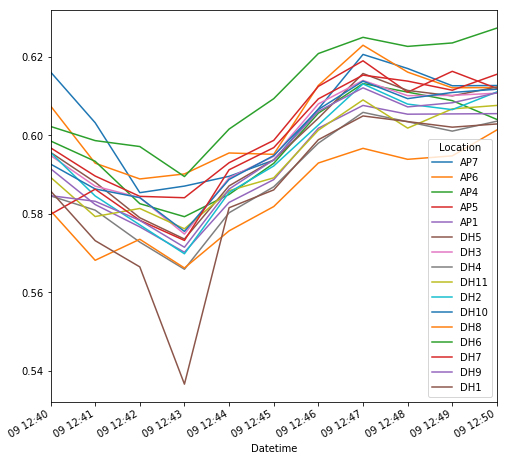

In [14]:
df.loc['2011-10-09 12:40':'2011-10-09 12:50'].plot(figsize=(8,8))

In [15]:
width= 11
step = 1
df_roll = df_to_roll(df,width=width,step=step)

# Some useful variables
longs_np = longs.index.to_numpy()
n_sensors = len(longs_np)
print('Number of sensors considered:',n_sensors)
times = df_roll.columns.levels[0].tolist()
chosen_times = times[1:width:step]
print('Chosen times slices as features:',chosen_times)
print('Number of time slices considered:',len(chosen_times))

# Split train-test, approximately 12 and 4 months respectively
df_train, df_test = df_roll[:'2011-07-31'], df_roll['2011-08-01':]

Number of sensors considered: 16
Chosen times slices as features: ['t-1', 't-10', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9']
Number of time slices considered: 10


# Train Model

## Imports

In [16]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [17]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add, Multiply, Subtract, Dropout
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected1D, Conv1D, UpSampling1D, MaxPooling1D, Dot, Concatenate
from keras.layers import LocallyConnected2D, Conv2D
from keras import backend as K
from clr import CyclicLR
from keras.layers import Layer, Conv2D, MaxPool2D, Flatten, Dense
from keras.initializers import Ones, Zeros

Using TensorFlow backend.


In [273]:
from keras.callbacks import Callback
import warnings
# from keras.callbacks import ReduceLROnPlateau
class ReduceLROnPlateauCyclic(Callback):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    # Example
    ```python
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.001)
    model.fit(X_train, Y_train, callbacks=[reduce_lr])
    ```
    # Arguments
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will
            be reduced. new_lr = lr * factor
        patience: number of epochs with no improvement
            after which learning rate will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of {auto, min, max}. In `min` mode,
            lr will be reduced when the quantity
            monitored has stopped decreasing; in `max`
            mode it will be reduced when the quantity
            monitored has stopped increasing; in `auto`
            mode, the direction is automatically inferred
            from the name of the monitored quantity.
        min_delta: threshold for measuring the new optimum,
            to only focus on significant changes.
        cooldown: number of epochs to wait before resuming
            normal operation after lr has been reduced.
        min_lr: lower bound on the learning rate.
    """

                 
    def __init__(self,classCyclicLR, monitor='val_loss', factor=0.1, patience=10,
                 verbose=0, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0,
                 **kwargs):
        super(ReduceLROnPlateauCyclic, self).__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError('ReduceLROnPlateauCyclic '
                             'does not support a factor >= 1.0.')
        if 'epsilon' in kwargs:
            min_delta = kwargs.pop('epsilon')
            warnings.warn('`epsilon` argument is deprecated and '
                          'will be removed, use `min_delta` instead.')
        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self._reset()
        self.classCyclicLR = classCyclicLR

    def _reset(self):
        """Resets wait counter and cooldown counter.
        """
        if self.mode not in ['auto', 'min', 'max']:
            warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
                          'fallback to auto mode.' % (self.mode),
                          RuntimeWarning)
            self.mode = 'auto'
        if (self.mode == 'min' or
           (self.mode == 'auto' and 'acc' not in self.monitor)):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(
                'Reduce LR on plateau conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )

        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = float(K.get_value(self.model.optimizer.lr))
                    if old_lr > self.min_lr:
                        new_lr = old_lr * self.factor
                        new_lr = max(new_lr, self.min_lr)
#                         K.set_value(self.model.optimizer.lr, new_lr)
                        old_factor = self.classCyclicLR.scale_fn(1.)
                        self.classCyclicLR.scale_fn = lambda x: old_factor*self.factor
                        if self.verbose > 0:
                            print('\nEpoch %05d: ReduceLROnPlateau reducing '
                                  'learning rate to %s.' % (epoch + 1, new_lr))
                        self.cooldown_counter = self.cooldown
                        self.wait = 0
    def in_cooldown(self):
        return self.cooldown_counter > 0
    
    
from keras.callbacks import *


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.

    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

        
import telegram
from keras.callbacks import Callback


class TelegramCallback(Callback):

    def __init__(self, config, name=None):
        super(TelegramCallback, self).__init__()
        self.user_id = config['telegram_id']
        self.bot = telegram.Bot(config['token'])
        if name != None:
            self.name = name
        else:
            self.name = self.model.name

    def send_message(self, text):
        try:
            self.bot.send_message(chat_id=self.user_id, text=text)
        except Exception as e:
            print('Message did not send. Error: {}.'.format(e))

    def on_train_begin(self, logs={}):
        text = 'Start training model {}.'.format(self.name)
        self.send_message(text)

    def on_train_end(self, logs={}):
        text = 'Training model {} ended.'.format(self.name)
        self.send_message(text)

    def on_epoch_end(self, epoch, logs={}):
        text = '{}: Epoch {}.\n'.format(self.name, epoch)
        for k, v in logs.items():
            if k != "lr":
                text += '{}: {:.4f}; '.format(k, v)
            else:
                text += '{}: {:.6f}; '.format(k, v) #4 decimal places too short for learning rate
        self.send_message(text)

In [278]:
model.name

'model_55'

## Hyperparameters

In [247]:
# LEARNING RATE
# lr = 0.00001
# max_lr=0.02
# batch_size = 1 << 8
# iters = int(len(df_train)/batch_size)
# c2 = CyclicLR(step_size=iters, base_lr=lr,max_lr=max_lr)
# TRAIN
# lr = 0.0005
# max_lr=0.018
lr = 0.00001
max_lr=0.0005
batch_size = 1 << 12   # as big as possible so we can explore many models
iters = int(len(df_train)/batch_size)
# epochs = 1 << 5
epochs = 1 << 10
min_lr = 0.0001
max_lr=0.0005
opt = keras.optimizers.Adam(lr=min_lr)
# We add a callback to log metrics and another one to schedule the learning rate
#see clr.py in this same folder

c1 = keras.callbacks.BaseLogger(stateful_metrics=None)

c3 = keras.callbacks.History()

c4 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                   patience=20, verbose=0, mode='min', 
                                   restore_best_weights=False)
c2 = CyclicLR(step_size=iters*8, base_lr=min_lr,max_lr=max_lr, mode='exp_range', gamma=0.9999)
c5 = ReduceLROnPlateauCyclic(c2,verbose=1,factor=0.5,min_lr=min_lr, mode='min')
c6 = keras.callbacks.TensorBoard(log_dir='./logs/exp_range', histogram_freq=0, batch_size=batch_size, 
                                 write_graph=False, write_grads=False, write_images=False,
                                 embeddings_freq=0, embeddings_layer_names=None, 
                                 embeddings_metadata=None,embeddings_data=None, 
                                 update_freq='epoch')
callbacks = [c2,c5,c6]

In [248]:
def set_lr(df_roll_train,chosen_times, to_array , make_model ,k_folds_val = 5,epochs = 1,verbose = 0):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, reverse_times = True)
    time_slices = len(chosen_times)
    n_sensors = y_tr.shape[1]
    
#     mean_mae_val_list = np.zeros(k_folds_val)
    mae_val_list = np.zeros((k_folds_val,n_sensors))
    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
#     for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=k_folds_val).split(X_tr)):
    model = make_model(n_sensors=n_sensors,time_slices=time_slices)
    model.compile(optimizer = opt, loss='mean_absolute_error')

    model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, shuffle=False,
              callbacks=callbacks, verbose=verbose)
    h = c2.history
    lr_ = h['lr']
    acc_ = h['loss']
#         plt.scatter(lr_,acc_)
    sns.scatterplot(lr_,acc_)
#         plt.xlim(0,10*max_lr)
#         plt.xscale('log')
    plt.show()
    return model, mae_val_list

In [267]:
def test():
    1+1
    return 
[3]+[2]+[]

[3, 2]

In [281]:
def train_and_validate(df_roll_train,chosen_times, to_array , make_model ,k_folds_val = 5,epochs = 32,verbose = 0, label_logs='', reduce_lr_plateau = False,
                      min_lr = 0.0001,max_lr=0.0008, telegram_bot = True):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, reverse_times = True)
    time_slices = len(chosen_times)
    n_sensors = y_tr.shape[1]
    

    mae_val_list = np.zeros((k_folds_val,n_sensors))
    mae_rel_val_list = np.zeros((k_folds_val,n_sensors))

    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
    for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=k_folds_val).split(X_tr)):
        iters = int(len(tr_idx)/batch_size)
        opt = keras.optimizers.Adam(lr=min_lr)
        cb_cycliclr = [CyclicLR(step_size=iters*4, base_lr=min_lr,max_lr=max_lr, mode='triangular', gamma=0.9999)]
        if telegram_bot:
            # create callback
            config = {
                'token': '849215732:AAE4zuC0XTB-ZDl6TDhKFKmBH5_FNm4dwD4',   # paste your bot token
                'telegram_id': 623819349,                                   # paste your telegram_id
            }
            cb_telegram = [TelegramCallback(config, name=label_logs+'_fold_'+str(i))]
        else:
            cb_telegram = []
        if reduce_lr_plateau:
            cb_plateau = [ReduceLROnPlateauCyclic(cb_cycliclr,verbose=1,patiente = 10,factor=0.5,min_lr=min_lr*5, mode='min')]
        else:
            cb_plateau = []
        cb_tensorboard = [keras.callbacks.TensorBoard(log_dir='./logs/exp_range_fold_'+str(i+1)+label_logs, histogram_freq=0, batch_size=batch_size, 
                                 write_graph=False, write_grads=False, write_images=False,
                                 embeddings_freq=0, embeddings_layer_names=None, 
                                 embeddings_metadata=None,embeddings_data=None, 
                                 update_freq='epoch')]
        callbacks = cb_cycliclr+cb_plateau+cb_tensorboard+cb_telegram
        model = make_model(n_sensors=n_sensors,time_slices=time_slices)
        model.compile(optimizer = opt, loss='mean_absolute_percentage_error', metrics = ['mean_absolute_error'])
        
        model.fit(X_tr[tr_idx], y_tr[tr_idx], batch_size=batch_size, shuffle=False,
                  epochs=epochs, validation_data=
              (X_tr[va_idx],y_tr[va_idx]), callbacks=callbacks, verbose=verbose)
        pred = model.predict(X_tr[va_idx])
        mae_val_list[i] = np.mean(np.abs(pred-y_tr[va_idx]),axis=0)
        mae_rel_val_list[i] = 100*np.mean(np.abs(pred/y_tr[va_idx]-1),axis=0)
        if verbose>0:
            print('MAE_val ', mae_val_list[i].mean() ) 

    return model, mae_val_list, mae_rel_val_list

In [275]:
def train_on_test(df_roll_train,chosen_times,to_array,make_model,epochs=32,verbose=0):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, reverse_times = True)
    time_slices = len(chosen_times)
    n_sensors = y_tr.shape[1]
    iters = int(len(df_roll_train)/batch_size)

    c2 = CyclicLR(step_size=iters*8, base_lr=min_lr,max_lr=max_lr, mode='exp_range', gamma=0.9999)
    c5 = ReduceLROnPlateauCyclic(c2,monitor = 'loss',verbose=1,patiente = 10,factor=0.5,min_lr=min_lr, mode='min')
    c6 = keras.callbacks.TensorBoard(log_dir='./logs/exp_range_train', histogram_freq=0, batch_size=batch_size, 
                             write_graph=False, write_grads=False, write_images=False,
                             embeddings_freq=0, embeddings_layer_names=None, 
                             embeddings_metadata=None,embeddings_data=None, 
                             update_freq='epoch')
    callbacks = [c2,c5,c6]
    
    model = make_model(n_sensors=n_sensors,time_slices=time_slices)
    model.compile(optimizer = opt, loss='mean_absolute_error')
    model.fit(X_tr, y_tr, batch_size=batch_size, shuffle=False,
              epochs=epochs, callbacks=callbacks, verbose=verbose)

    return model

In [276]:
def print_mae_sensors(mae_val_list,longs_np, scale = 1):
    """
    mae_val_list : (k_folds_val, n_sensors)
    longs_np : (n_sensors)
    """
    mae_val_list = scale*mae_val_list
    print('====MAE VALIDATION=====')
    print('* MEAN: {:0.3f} (+/- {:0.3f})'.format(mae_val_list.mean(), mae_val_list.std()),
      '/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_val_list.mean(axis=1)]),']')
    print('====DISAGGREGATED======')
    for sensor,mae_list in zip(longs_np,mae_val_list.T):
        print("* {:4}: {:0.3f} (+/- {:0.3f})".format(sensor, mae_list.mean(), mae_list.std()),'/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_list]),']') 

## Conv2D Clearsky

====MAE VALIDATION=====
* MEAN: 0.075 (+/- 0.029) / List: [  0.109,  0.069,  0.033,  0.065,  0.102 ]

====DISAGGREGATED======
* AP7 : 0.092 (+/- 0.036) / List: [  0.132,  0.084,  0.036,  0.076,  0.132 ]
* AP6 : 0.090 (+/- 0.037) / List: [  0.130,  0.081,  0.034,  0.071,  0.133 ]
* AP4 : 0.083 (+/- 0.033) / List: [  0.118,  0.073,  0.034,  0.068,  0.121 ]
* AP5 : 0.072 (+/- 0.025) / List: [  0.099,  0.062,  0.034,  0.062,  0.101 ]
* AP1 : 0.070 (+/- 0.025) / List: [  0.100,  0.066,  0.031,  0.060,  0.092 ]
* DH5 : 0.073 (+/- 0.026) / List: [  0.105,  0.071,  0.032,  0.061,  0.094 ]
* DH3 : 0.076 (+/- 0.025) / List: [  0.107,  0.068,  0.036,  0.073,  0.098 ]
* DH4 : 0.071 (+/- 0.026) / List: [  0.104,  0.067,  0.031,  0.061,  0.093 ]
* DH11: 0.071 (+/- 0.028) / List: [  0.113,  0.062,  0.032,  0.059,  0.088 ]
* DH2 : 0.078 (+/- 0.029) / List: [  0.114,  0.075,  0.033,  0.065,  0.101 ]
* DH10: 0.068 (+/- 0.024) / List: [  0.098,  0.062,  0.031,  0.059,  0.090 ]
* DH8 : 0.067 (+/- 0.022) / List: [  0.092,  0.062,  0.033,  0.057,  0.088 ]
* DH6 : 0.067 (+/- 0.024) / List: [  0.097,  0.060,  0.031,  0.059,  0.090 ]
* DH7 : 0.076 (+/- 0.028) / List: [  0.111,  0.071,  0.033,  0.062,  0.100 ]
* DH9 : 0.073 (+/- 0.025) / List: [  0.102,  0.064,  0.032,  0.073,  0.096 ]
* DH1 : 0.080 (+/- 0.030) / List: [  0.117,  0.076,  0.033,  0.067,  0.107 ]

In [71]:
def make_model_all_conv2d( n_sensors=17, time_slices = 1):
    ''' Returns a model using all the sensors to predict index_sensor 
    Input shape : (items, time_slice, sensor, 1), 'channels_last'
    '''
    xin = Input(shape=(n_sensors,time_slices,1), name='main_input')
    '''
    When using this layer as the first layer in a model, provide an input_shape argument 
    (tuple of integers or None, does not include the batch axis), e.g. input_shape=(10, 128) 
    for time series sequences of 10 time steps with 128 features per step in data_format="channels_last", 
    or (None, 128) for variable-length sequences with 128 features per step.
    '''
    # The convolution is across time, and each sensor is a channel
    x = LocallyConnected2D(n_sensors, 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon1')(xin)
#     x = keras.layers.AveragePooling2D((2,2))(x)
    x = LocallyConnected2D(int(n_sensors/2), 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon2')(x)
    x = Conv2D(n_sensors, 3, data_format = 'channels_last', padding='valid', name='Con1')(x)
    xl = Dropout(0.2,name='Dropout')(Flatten(name='Flatten1')(x))
    
    # First features
    xo = Dense(2*n_sensors, name='CFeatDense1',activation='relu')(xl)
    xo = Dense(n_sensors, name='CFeatFDense2',activation='relu')(xo)
    # Shape (batch_size)*(n_sensors,1)
    xo_reshaped = Reshape((n_sensors,1), name = 'CFeatFReshape')(xo)
    
    # sort of residual connection, we only take the last timestamp of the given sensor x[:,-1:,index_sensor]
    xin_0 = Activation('relu',name='RFeatRelu')(xin)
    # Shape (batch_size)*(n_sensors,1)
    xin_1 = Lambda(lambda x : x[:,:,-1:,0],name='RFeatLambda')(xin_0)
    
    # Weights
    # use date info here?
    xinf = Flatten()(xin)
    s  = Dense(5*n_sensors, activation='tanh',name='WFeatDense1')(xinf)
    s  = Dense(4*n_sensors, activation='tanh',name='WFeatDense2')(s)
    s  = Dense(3*n_sensors, activation='tanh',name='WFeatDense3')(s)
    s = Dense(2*n_sensors, name='WFeatDense4',activation='sigmoid')(s)
    weights = Reshape((n_sensors,2),name='WFeatReshape')(s)
    # Softmax over the second axis, this is, we 2 values that sum up to one for each sensor.
#     s = Lambda(lambda x : keras.activations.softmax(x,axis=2), name = 'WFeatSoftmax')(s)
#     s = Activation(keras.activations.softmax(x,axis=1))(s)
    
    # Check dimensions here, and the axes for Concatenate and Dot, we want n_sensors outputs
    # Shape (batch_size)*(n_sensors,2)
    # Notation alert! The axis here is counting the batch_size one.
    x_concat = Concatenate(axis=2, name='ConcatCandR')([xo_reshaped,xin_1])
    
    x_weighted = keras.layers.Multiply(name='Multiply')([x_concat,weights])
    x_sum = Lambda(lambda x: K.sum(x, axis=2))(x_weighted)
#     xo_m = Dot(axes=2, name='WeightedMean')([x_concat, weights])
    # We need to take the diagonal
#     def diagonal(tensor):
#         out = []
#         for i in range(n_sensors):
#             out.append(tensor[:,i:i+1,i])
#         return out
#     xo_m = Lambda(diagonal, name='Diagonal')(xo_m)
#     x_sum = Concatenate(axis=1, name='Tensorize')(xo_m)
    
    # We want positive results
    x_final = Activation('relu', name='FinalRelu')(x_sum)
    model = Model(inputs=[xin], outputs=[x_final])
    return model

In [245]:
def make_model_all_conv2d_deeper(n_sensors=17, time_slices = 1):
    ''' Returns a model using all the sensors to predict index_sensor 
    Input shape : (items, time_slice, sensor, 1), 'channels_last'
    '''
    xin = Input(shape=(n_sensors,time_slices,1), name='main_input')
    '''
    When using this layer as the first layer in a model, provide an input_shape argument 
    (tuple of integers or None, does not include the batch axis), e.g. input_shape=(10, 128) 
    for time series sequences of 10 time steps with 128 features per step in data_format="channels_last", 
    or (None, 128) for variable-length sequences with 128 features per step.
    '''
    # The convolution is across time, and each sensor is a channel
    x = LocallyConnected2D(n_sensors, 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon1')(xin)
#     x = keras.layers.AveragePooling2D((2,2))(x)
    x = LocallyConnected2D(int(n_sensors/2), 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon2')(x)
    x = Conv2D(n_sensors, 3, data_format = 'channels_last', padding='valid', name='Con1')(x)
    xl = Dropout(0.2,name='Dropout')(Flatten(name='Flatten1')(x))
    
    # First features
    xo = Dense(4*n_sensors, name='CFeatDense1',activation='relu')(xl)
    xo = Dense(3*n_sensors, name='CFeatFDense2',activation='relu')(xo)
    xo = Dense(2*n_sensors, name='CFeatFDense3',activation='relu')(xo)
    xo = Dense(2*n_sensors, name='CFeatFDense4',activation='relu')(xo)
    xo = Dense(n_sensors, name='CFeatFDense5',activation='relu')(xo)
    # Shape (batch_size)*(n_sensors,1)
    xo_reshaped = Reshape((n_sensors,1), name = 'CFeatFReshape')(xo)
    
    # sort of residual connection, we only take the last timestamp of the given sensor x[:,-1:,index_sensor]
    xin_0 = Activation('relu',name='RFeatRelu')(xin)
    # Shape (batch_size)*(n_sensors,1)
    xin_1 = Lambda(lambda x : x[:,:,-1:,0],name='RFeatLambda')(xin_0)
    
    # Weights
    # use date info here?
    xinf = Flatten()(xin)
    s  = Dense(5*n_sensors, activation='tanh',name='WFeatDense1')(xinf)
    s  = Dense(4*n_sensors, activation='tanh',name='WFeatDense2')(s)
    s  = Dense(3*n_sensors, activation='tanh',name='WFeatDense3')(s)
    s  = Dense(2*n_sensors, activation='tanh',name='WFeatDense4')(s)
    s  = Dense(2*n_sensors, activation='tanh',name='WFeatDense5')(s)
    s = Dense(2*n_sensors, name='WFeatDenseProbs',activation='sigmoid')(s)
    weights = Reshape((n_sensors,2),name='WFeatReshape')(s)
    # Softmax over the second axis, this is, we 2 values that sum up to one for each sensor.
#     s = Lambda(lambda x : keras.activations.softmax(x,axis=2), name = 'WFeatSoftmax')(s)
#     s = Activation(keras.activations.softmax(x,axis=1))(s)
    
    # Check dimensions here, and the axes for Concatenate and Dot, we want n_sensors outputs
    # Shape (batch_size)*(n_sensors,2)
    # Notation alert! The axis here is counting the batch_size one.
    x_concat = Concatenate(axis=2, name='ConcatCandR')([xo_reshaped,xin_1])
    
    x_weighted = keras.layers.Multiply(name='Multiply')([x_concat,weights])
    x_sum = Lambda(lambda x: K.sum(x, axis=2))(x_weighted)
#     xo_m = Dot(axes=2, name='WeightedMean')([x_concat, weights])
    # We need to take the diagonal
#     def diagonal(tensor):
#         out = []
#         for i in range(n_sensors):
#             out.append(tensor[:,i:i+1,i])
#         return out
#     xo_m = Lambda(diagonal, name='Diagonal')(xo_m)
#     x_sum = Concatenate(axis=1, name='Tensorize')(xo_m)
    
    # We want positive results
    x_final = Activation('relu', name='FinalRelu')(x_sum)
    model = Model(inputs=[xin], outputs=[x_final])
    return model

In [ ]:
# model = make_model_all_conv2d(n_sensors,len(chosen_times))
# model.summary()

Epoch 1/1


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250390). Check your callbacks.
  % delta_t_median)


 - 40s - loss: 0.1044


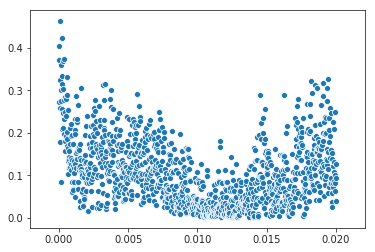

In [54]:
model, mae_val_list = set_lr(df_train,chosen_times,
                                         to_array_cov2d,
                                         make_model_all_conv2d,
                                         epochs=1,
                                         verbose=2)

In [33]:
lr

1e-06

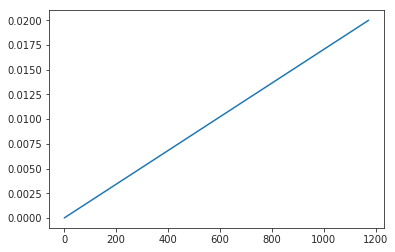

In [56]:
sns.lineplot(c2.history['iterations'],c2.history['lr'])

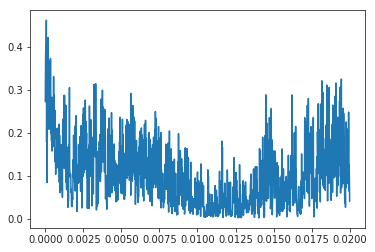

In [60]:
sns.set_style('ticks')
sns.lineplot(c2.history['lr'],c2.history['loss'])
# plt.xscale('log')

In [ ]:
model, mae_val_list = train_and_validate(df_train,chosen_times,
                                         to_array_cov2d,
                                         make_model_all_conv2d,
                                         epochs=epochs,
                                         verbose=2)
print_mae_sensors(mae_val_list,longs_np)

Train on 50015 samples, validate on 50014 samples
Epoch 1/1024


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.379929). Check your callbacks.
  % delta_t_median)


 - 8s - loss: 0.3335 - val_loss: 0.3187
Epoch 2/1024
 - 1s - loss: 0.2775 - val_loss: 0.2499
Epoch 3/1024
 - 1s - loss: 0.2035 - val_loss: 0.1736
Epoch 4/1024
 - 1s - loss: 0.1572 - val_loss: 0.1556
Epoch 5/1024
 - 1s - loss: 0.1443 - val_loss: 0.1464
Epoch 6/1024
 - 1s - loss: 0.1384 - val_loss: 0.1423
Epoch 7/1024
 - 1s - loss: 0.1352 - val_loss: 0.1398
Epoch 8/1024
 - 1s - loss: 0.1331 - val_loss: 0.1379
Epoch 9/1024
 - 1s - loss: 0.1315 - val_loss: 0.1364
Epoch 10/1024
 - 1s - loss: 0.1303 - val_loss: 0.1351
Epoch 11/1024
 - 1s - loss: 0.1292 - val_loss: 0.1338
Epoch 12/1024
 - 1s - loss: 0.1282 - val_loss: 0.1325
Epoch 13/1024
 - 1s - loss: 0.1272 - val_loss: 0.1314
Epoch 14/1024
 - 1s - loss: 0.1262 - val_loss: 0.1313
Epoch 15/1024
 - 1s - loss: 0.1253 - val_loss: 0.1292
Epoch 16/1024
 - 1s - loss: 0.1243 - val_loss: 0.1284
Epoch 17/1024
 - 1s - loss: 0.1235 - val_loss: 0.1274
Epoch 18/1024
 - 1s - loss: 0.1227 - val_loss: 0.1264
Epoch 19/1024
 - 1s - loss: 0.1219 - val_loss: 0.1

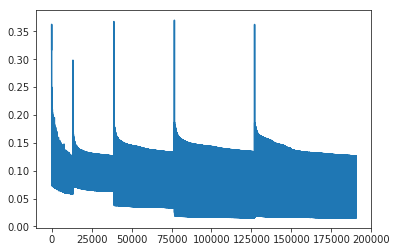

In [81]:
sns.lineplot(c2.history['iterations'],c2.history['loss'])

In [280]:
model, mae_val_list, mae_rel_val_list = train_and_validate(df_train,chosen_times,
                                         to_array_cov2d,
                                         make_model_all_conv2d,
                                         epochs=32,
                                         verbose=2,
                                        label_logs='_not_plateau',
                                        reduce_lr_plateau=False,
                                        min_lr=1e-4,
                                         max_lr=8e-4 )
print_mae_sensors(mae_val_list,longs_np)
print_mae_sensors(mae_rel_val_list,longs_np)

Train on 50015 samples, validate on 50014 samples
Epoch 1/32


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (5.211466). Check your callbacks.
  % delta_t_median)


 - 43s - loss: 51.8438 - mean_absolute_error: 0.3590 - val_loss: 45.7998 - val_mean_absolute_error: 0.3225
Epoch 2/32
 - 1s - loss: 39.0738 - mean_absolute_error: 0.2585 - val_loss: 35.3542 - val_mean_absolute_error: 0.2148
Epoch 3/32
 - 1s - loss: 31.4930 - mean_absolute_error: 0.1929 - val_loss: 31.4655 - val_mean_absolute_error: 0.1969
Epoch 4/32
 - 1s - loss: 28.5964 - mean_absolute_error: 0.1690 - val_loss: 29.1000 - val_mean_absolute_error: 0.1741
Epoch 5/32
 - 1s - loss: 26.7779 - mean_absolute_error: 0.1531 - val_loss: 27.8839 - val_mean_absolute_error: 0.1594
Epoch 6/32
 - 1s - loss: 25.9420 - mean_absolute_error: 0.1466 - val_loss: 27.2031 - val_mean_absolute_error: 0.1479
Epoch 7/32
 - 1s - loss: 25.3210 - mean_absolute_error: 0.1410 - val_loss: 26.9758 - val_mean_absolute_error: 0.1467
Epoch 8/32
 - 1s - loss: 25.1446 - mean_absolute_error: 0.1390 - val_loss: 26.8650 - val_mean_absolute_error: 0.1459
Epoch 9/32
 - 1s - loss: 25.0303 - mean_absolute_error: 0.1379 - val_loss:

/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (4.785097). Check your callbacks.
  % delta_t_median)


 - 41s - loss: 46.0610 - mean_absolute_error: 0.3164 - val_loss: 34.2613 - val_mean_absolute_error: 0.1857
Epoch 2/32
 - 2s - loss: 32.2255 - mean_absolute_error: 0.1970 - val_loss: 25.0645 - val_mean_absolute_error: 0.1210
Epoch 3/32
 - 2s - loss: 27.2321 - mean_absolute_error: 0.1541 - val_loss: 21.7650 - val_mean_absolute_error: 0.0998
Epoch 4/32
 - 2s - loss: 25.5139 - mean_absolute_error: 0.1397 - val_loss: 20.2561 - val_mean_absolute_error: 0.0905
Epoch 5/32
 - 2s - loss: 24.6975 - mean_absolute_error: 0.1343 - val_loss: 19.5915 - val_mean_absolute_error: 0.0883
Epoch 6/32
 - 2s - loss: 24.3269 - mean_absolute_error: 0.1329 - val_loss: 19.3235 - val_mean_absolute_error: 0.0874
Epoch 7/32
 - 2s - loss: 24.1162 - mean_absolute_error: 0.1321 - val_loss: 19.1721 - val_mean_absolute_error: 0.0862
Epoch 8/32
 - 2s - loss: 23.9843 - mean_absolute_error: 0.1315 - val_loss: 19.0882 - val_mean_absolute_error: 0.0863
Epoch 9/32
 - 3s - loss: 23.8962 - mean_absolute_error: 0.1312 - val_loss:

/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (4.579593). Check your callbacks.
  % delta_t_median)


 - 43s - loss: 39.6683 - mean_absolute_error: 0.2551 - val_loss: 25.3535 - val_mean_absolute_error: 0.0871
Epoch 2/32
 - 3s - loss: 27.1035 - mean_absolute_error: 0.1494 - val_loss: 15.2542 - val_mean_absolute_error: 0.0479
Epoch 3/32
 - 4s - loss: 24.2241 - mean_absolute_error: 0.1252 - val_loss: 12.5073 - val_mean_absolute_error: 0.0404
Epoch 4/32
 - 3s - loss: 22.9324 - mean_absolute_error: 0.1185 - val_loss: 11.5213 - val_mean_absolute_error: 0.0379
Epoch 5/32
 - 3s - loss: 22.2298 - mean_absolute_error: 0.1152 - val_loss: 11.2226 - val_mean_absolute_error: 0.0370
Epoch 6/32
 - 4s - loss: 21.8384 - mean_absolute_error: 0.1136 - val_loss: 10.8224 - val_mean_absolute_error: 0.0361
Epoch 7/32
 - 3s - loss: 21.5889 - mean_absolute_error: 0.1129 - val_loss: 10.7657 - val_mean_absolute_error: 0.0362
Epoch 8/32
 - 3s - loss: 21.4243 - mean_absolute_error: 0.1123 - val_loss: 10.6881 - val_mean_absolute_error: 0.0359
Epoch 9/32
 - 4s - loss: 21.3416 - mean_absolute_error: 0.1121 - val_loss:

/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (4.451633). Check your callbacks.
  % delta_t_median)


 - 44s - loss: 37.2024 - mean_absolute_error: 0.2234 - val_loss: 22.5940 - val_mean_absolute_error: 0.1216
Epoch 2/32
 - 5s - loss: 23.5852 - mean_absolute_error: 0.1194 - val_loss: 18.0035 - val_mean_absolute_error: 0.0869
Epoch 3/32
 - 4s - loss: 21.0218 - mean_absolute_error: 0.1029 - val_loss: 16.2711 - val_mean_absolute_error: 0.0802
Epoch 4/32
 - 4s - loss: 19.8181 - mean_absolute_error: 0.0971 - val_loss: 15.6126 - val_mean_absolute_error: 0.0761
Epoch 5/32
 - 4s - loss: 19.3025 - mean_absolute_error: 0.0947 - val_loss: 15.2803 - val_mean_absolute_error: 0.0751
Epoch 6/32
 - 4s - loss: 18.9907 - mean_absolute_error: 0.0936 - val_loss: 14.8651 - val_mean_absolute_error: 0.0740
Epoch 7/32
 - 4s - loss: 18.7626 - mean_absolute_error: 0.0930 - val_loss: 14.8222 - val_mean_absolute_error: 0.0748
Epoch 8/32
 - 5s - loss: 18.6216 - mean_absolute_error: 0.0927 - val_loss: 14.6767 - val_mean_absolute_error: 0.0735
Epoch 9/32
 - 5s - loss: 18.5403 - mean_absolute_error: 0.0925 - val_loss:

/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (4.649807). Check your callbacks.
  % delta_t_median)


 - 48s - loss: 35.2468 - mean_absolute_error: 0.2092 - val_loss: 28.2641 - val_mean_absolute_error: 0.1664
Epoch 2/32
 - 6s - loss: 21.9033 - mean_absolute_error: 0.1085 - val_loss: 25.0822 - val_mean_absolute_error: 0.1361
Epoch 3/32
 - 5s - loss: 19.6602 - mean_absolute_error: 0.0957 - val_loss: 24.2472 - val_mean_absolute_error: 0.1376
Epoch 4/32
 - 5s - loss: 18.8144 - mean_absolute_error: 0.0924 - val_loss: 23.6840 - val_mean_absolute_error: 0.1342
Epoch 5/32
 - 6s - loss: 18.3318 - mean_absolute_error: 0.0907 - val_loss: 23.2840 - val_mean_absolute_error: 0.1336
Epoch 6/32
 - 5s - loss: 18.0305 - mean_absolute_error: 0.0900 - val_loss: 22.6390 - val_mean_absolute_error: 0.1290
Epoch 7/32
 - 5s - loss: 17.7484 - mean_absolute_error: 0.0893 - val_loss: 22.2730 - val_mean_absolute_error: 0.1285
Epoch 8/32
 - 6s - loss: 17.5853 - mean_absolute_error: 0.0889 - val_loss: 22.1155 - val_mean_absolute_error: 0.1286
Epoch 9/32
 - 6s - loss: 17.4927 - mean_absolute_error: 0.0888 - val_loss:

In [254]:
print_mae_sensors(mae_val_list,longs_np)
print_mae_sensors(mae_rel_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.083 (+/- 0.033) / List: [  0.117,  0.077,  0.035,  0.069,  0.117 ]
====DISAGGREGATED======
* AP7 : 0.104 (+/- 0.043) / List: [  0.153,  0.093,  0.040,  0.085,  0.149 ]
* AP6 : 0.100 (+/- 0.041) / List: [  0.146,  0.093,  0.038,  0.078,  0.144 ]
* AP4 : 0.092 (+/- 0.038) / List: [  0.132,  0.082,  0.035,  0.075,  0.136 ]
* AP5 : 0.080 (+/- 0.029) / List: [  0.112,  0.071,  0.036,  0.071,  0.112 ]
* AP1 : 0.079 (+/- 0.029) / List: [  0.102,  0.079,  0.033,  0.065,  0.115 ]
* DH5 : 0.078 (+/- 0.027) / List: [  0.110,  0.077,  0.034,  0.066,  0.103 ]
* DH3 : 0.082 (+/- 0.028) / List: [  0.111,  0.089,  0.035,  0.068,  0.105 ]
* DH4 : 0.077 (+/- 0.026) / List: [  0.109,  0.073,  0.037,  0.065,  0.101 ]
* DH11: 0.072 (+/- 0.024) / List: [  0.100,  0.067,  0.035,  0.065,  0.096 ]
* DH2 : 0.084 (+/- 0.031) / List: [  0.121,  0.083,  0.036,  0.069,  0.112 ]
* DH10: 0.073 (+/- 0.025) / List: [  0.104,  0.067,  0.033,  0.064,  0.096 ]
* DH8 : 0.077 (+/- 0.030) / 

In [235]:
print_mae_sensors(mae_val_list,longs_np)
print_mae_sensors(mae_rel_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.085 (+/- 0.033) / List: [  0.122,  0.081,  0.037,  0.070,  0.116 ]
====DISAGGREGATED======
* AP7 : 0.099 (+/- 0.039) / List: [  0.133,  0.093,  0.039,  0.081,  0.148 ]
* AP6 : 0.098 (+/- 0.040) / List: [  0.141,  0.093,  0.038,  0.077,  0.142 ]
* AP4 : 0.092 (+/- 0.037) / List: [  0.132,  0.084,  0.036,  0.073,  0.136 ]
* AP5 : 0.082 (+/- 0.028) / List: [  0.110,  0.074,  0.039,  0.073,  0.115 ]
* AP1 : 0.084 (+/- 0.033) / List: [  0.132,  0.079,  0.035,  0.067,  0.106 ]
* DH5 : 0.084 (+/- 0.031) / List: [  0.124,  0.084,  0.036,  0.068,  0.109 ]
* DH3 : 0.085 (+/- 0.030) / List: [  0.120,  0.085,  0.038,  0.070,  0.114 ]
* DH4 : 0.085 (+/- 0.033) / List: [  0.133,  0.082,  0.036,  0.068,  0.107 ]
* DH11: 0.076 (+/- 0.025) / List: [  0.105,  0.070,  0.035,  0.071,  0.098 ]
* DH2 : 0.090 (+/- 0.034) / List: [  0.126,  0.089,  0.037,  0.071,  0.125 ]
* DH10: 0.077 (+/- 0.026) / List: [  0.108,  0.075,  0.035,  0.066,  0.101 ]
* DH8 : 0.076 (+/- 0.026) / 

In [78]:
print_mae_sensors(mae_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.075 (+/- 0.029) / List: [  0.109,  0.069,  0.033,  0.065,  0.102 ]
====DISAGGREGATED======
* AP7 : 0.092 (+/- 0.036) / List: [  0.132,  0.084,  0.036,  0.076,  0.132 ]
* AP6 : 0.090 (+/- 0.037) / List: [  0.130,  0.081,  0.034,  0.071,  0.133 ]
* AP4 : 0.083 (+/- 0.033) / List: [  0.118,  0.073,  0.034,  0.068,  0.121 ]
* AP5 : 0.072 (+/- 0.025) / List: [  0.099,  0.062,  0.034,  0.062,  0.101 ]
* AP1 : 0.070 (+/- 0.025) / List: [  0.100,  0.066,  0.031,  0.060,  0.092 ]
* DH5 : 0.073 (+/- 0.026) / List: [  0.105,  0.071,  0.032,  0.061,  0.094 ]
* DH3 : 0.076 (+/- 0.025) / List: [  0.107,  0.068,  0.036,  0.073,  0.098 ]
* DH4 : 0.071 (+/- 0.026) / List: [  0.104,  0.067,  0.031,  0.061,  0.093 ]
* DH11: 0.071 (+/- 0.028) / List: [  0.113,  0.062,  0.032,  0.059,  0.088 ]
* DH2 : 0.078 (+/- 0.029) / List: [  0.114,  0.075,  0.033,  0.065,  0.101 ]
* DH10: 0.068 (+/- 0.024) / List: [  0.098,  0.062,  0.031,  0.059,  0.090 ]
* DH8 : 0.067 (+/- 0.022) / 

## Plot Test Prediction

In [139]:
model = train_on_test(df_train,chosen_times,
                             to_array_cov2d,
                             make_model_all_conv2d,
                             epochs=120,
                             verbose=2)

Epoch 1/120
 - 12s - loss: 0.1564
Epoch 2/120


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr


 - 4s - loss: 0.1042
Epoch 3/120
 - 5s - loss: 0.0995
Epoch 4/120
 - 4s - loss: 0.0970
Epoch 5/120
 - 5s - loss: 0.0954
Epoch 6/120
 - 4s - loss: 0.0940
Epoch 7/120
 - 5s - loss: 0.0934
Epoch 8/120
 - 4s - loss: 0.0922
Epoch 9/120
 - 5s - loss: 0.0914
Epoch 10/120
 - 4s - loss: 0.0906
Epoch 11/120
 - 5s - loss: 0.0898
Epoch 12/120
 - 4s - loss: 0.0895
Epoch 13/120
 - 5s - loss: 0.0889
Epoch 14/120
 - 4s - loss: 0.0886
Epoch 15/120
 - 5s - loss: 0.0884
Epoch 16/120
 - 4s - loss: 0.0882
Epoch 17/120
 - 5s - loss: 0.0882
Epoch 18/120
 - 4s - loss: 0.0882
Epoch 19/120
 - 5s - loss: 0.0881
Epoch 20/120
 - 4s - loss: 0.0880
Epoch 21/120
 - 5s - loss: 0.0878
Epoch 22/120
 - 4s - loss: 0.0876
Epoch 23/120
 - 4s - loss: 0.0876
Epoch 24/120
 - 5s - loss: 0.0873
Epoch 25/120
 - 4s - loss: 0.0871
Epoch 26/120
 - 5s - loss: 0.0866
Epoch 27/120
 - 4s - loss: 0.0865
Epoch 28/120
 - 4s - loss: 0.0863
Epoch 29/120
 - 4s - loss: 0.0862
Epoch 30/120
 - 4s - loss: 0.0861
Epoch 31/120
 - 4s - loss: 0.0859


In [220]:
X_test, y_test = to_array_cov2d(df_test)
y_pred = model.predict(X_test)

55292

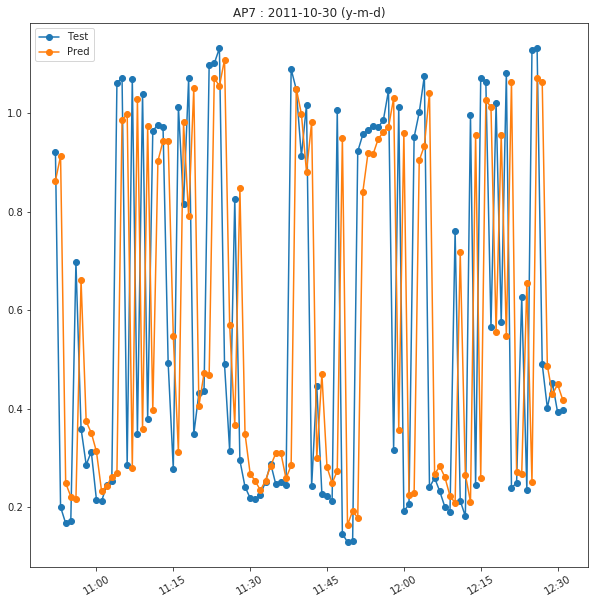

In [222]:
from matplotlib.dates import DateFormatter
from datetime import datetime
import pytz

sensor_idx = 0
idx_0 = 54292
idx_f = idx_0 + 100

day = str(df_test.index[idx_0]).split(' ')[0]

fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.title(longs_np[sensor_idx]+' : '+day+' (y-m-d)')

plt.plot_date(df_test[idx_0:idx_f].index,y_test[idx_0:idx_f,sensor_idx],label='Test',fmt='-o')
plt.plot_date(df_test[idx_0:idx_f].index,y_pred[idx_0:idx_f,sensor_idx],label='Pred',fmt='-o')
# ax.xaxis.set_major_locator(loc)
formatter = DateFormatter('%H:%M',tz = pytz.timezone('HST'))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.legend()
plt.show()

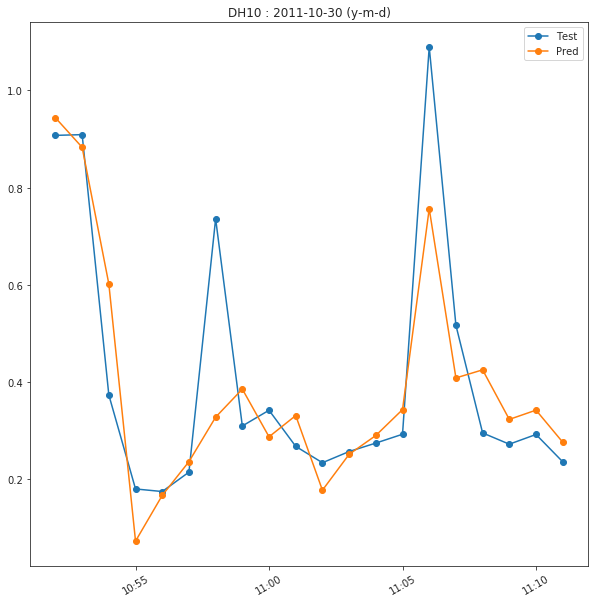

In [225]:
from matplotlib.dates import DateFormatter
from datetime import datetime
import pytz

sensor_idx = 10
idx_0 = 54292
idx_f = idx_0 + 20

day = str(df_test.index[idx_0]).split(' ')[0]

fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.title(longs_np[sensor_idx]+' : '+day+' (y-m-d)')

plt.plot_date(df_test[idx_0:idx_f].index,y_test[idx_0:idx_f,sensor_idx],label='Test',fmt='-o')
plt.plot_date(df_test[idx_0:idx_f].index,y_pred[idx_0:idx_f,sensor_idx],label='Pred',fmt='-o')
# ax.xaxis.set_major_locator(loc)
formatter = DateFormatter('%H:%M',tz = pytz.timezone('HST'))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.legend()
plt.show()